# Cylindrical Ring and Arahanov-Bohm Oscillations

I will use this notebook to study the DOS of a cylindrical conducting shell made of normal material. The aim is to reproduce the angular momemtum subband structure.

Once the DOS looks good, I will add an axial magnetic field in the system and see how it affects the sub-band structure.

The final step is to reproduce Arahanov-Bohm conductance oscillations using NEGF.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import scipy.special

In [4]:
# define a dummy class to pass parameters to functions
class Parameters:
    def __init__(self):
        return

In [5]:
# define the Hamiltonian
def calc_H(params):
    t_z = params.t_z
    t_phi = params.t_phi
    N_z = params.N_z
    N_phi = params.N_phi
    flux = params.flux
    mu = params.mu
    
    indices = list(itertools.product(range(N_z),range(N_phi)))
    def calc_H_element(x,y):
        if x == y:
            return 2*t_z + abs(t_phi)*(2 + (2*np.pi*flux/N_phi)**2) - mu
        elif (x[1]-y[1] == 1 or x[1]-y[1] == N_phi - 1) and x[0] == y[0]:
            return -t_phi
        elif (x[1]-y[1] == -1 or x[1]-y[1] == -N_phi + 1) and x[0] == y[0]:
            return -np.conj(t_phi)
        elif x[1] == y[1] and abs(x[0]-y[0]) == 1:
            return -t_z
        else:
            return 0.0
   
    # no messy flattening problem as compared to 2x2 Nambu matrices in BdG
    H_array = np.matrix(np.array([calc_H_element(x,y) for x in indices for y in indices]).reshape(N_phi*N_z,N_phi*N_z))
    return H_array

In [6]:
def calc_DOS(E,H):
    eta = 1e-2
    G = np.linalg.inv((E+1j*eta)*np.eye(H.shape[0]) - H)
    A = 1j*(G - np.conj(G).T) 
    dos = np.real(np.trace(A))
    return dos

I will now simulate a thick nanowire with less points in the length and more points in the circumference. The different l sub-bands are observed.

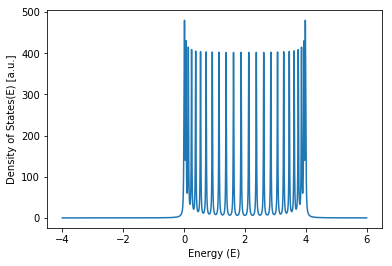

In [8]:
params = Parameters()
params.t_z = 1
params.flux = 0
params.t_phi = 1*np.exp(1j*2*np.pi*params.flux)
params.N_z = 1
params.N_phi = 50
params.mu = 2

H = calc_H(params)
E_linspace = np.linspace(-4,6,10000)
dos = np.array([calc_DOS(E,H) for E in E_linspace])

plt.plot(E_linspace,dos)
plt.xlabel('Energy (E)')
plt.ylabel('Density of States(E) [a.u.]')

I now want to introduce a magnetic field in the simulation. I think one way to do it is to add a phase to t_phi parameter.

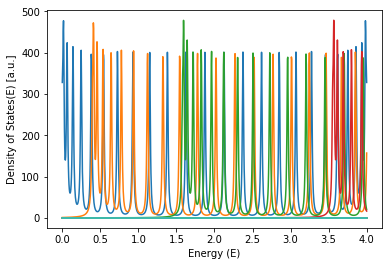

In [ ]:
for i in range(10):
    params = Parameters()
    params.N_z = 1
    params.N_phi = 50
    params.flux = 5*i
    params.t_z = 1
    params.t_phi = 1*np.exp(1j*2*np.pi*params.flux/N_phi)
    params.mu = 2

    H = calc_H(params)
    E_linspace = np.linspace(0,4,1000)
    dos = np.array([calc_DOS(E,H) for E in E_linspace])

    #plt.figure(i)
    plt.plot(E_linspace,dos)
    plt.xlabel('Energy (E)')
    plt.ylabel('Density of States(E) [a.u.]')
    #plt.title("flux" + str(params.flux))

In [17]:
# code for transport

def calc_current(E,params):
    if params.N_z < 2:
        raise Exception("Calculation of current requires atleast two logitudianl points in the device.")
    eta = 1e-10
    # calcualtion of the surface functions
    def surface_g(E,parmas):
        dummy_contact_params = Parameters()
        dummy_contact_params.N_z = 2
        dummy_contact_params.N_phi = params.N_phi
        dummy_contact_params.flux = params.flux
        dummy_contact_params.t_z = params.t_z
        dummy_contact_params.t_phi = params.t_phi
        dummy_contact_params.mu = params.mu
       
        H_mat = calc_H(dummy_contact_params)
        N_dof_lat = params.N_phi
        alpha = H_mat[:N_dof_lat,:N_dof_lat]
        beta = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]

        err = 1.0
        iter_count = 0
        iter_limit = 100000
        err_limit = 1e-6

        g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha)
        g_old = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha)
        # iterate over iter_limit iterations or until err < err_limit
        for i in range(iter_limit):
            g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha - np.dot(np.dot(np.conj(beta.T),g),beta))
            g = 0.5*(g + g_old)

            err = np.linalg.norm(g-g_old)/np.sqrt(np.linalg.norm(g)*np.linalg.norm(g_old))
            g_old = g
            if(err < err_limit):
                #print("Finished at",i,"Error :",err)
                break;
            if(i == (iter_limit - 1)):
                print("iter_limit hit in calculation of surface_g",err)
        return np.matrix(g)
        
    g_1 = surface_g(E,params)
    g_2 = surface_g(E,params)
    
    H_mat = calc_H(params)
    #number of dof in a layer
    N_dof_lat = params.N_phi
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = beta_layer.H @ g_1 @ beta_layer
    sigma_mini_2 = beta_layer.H @ g_2 @ beta_layer
    
    sigma_1 = np.matrix(np.zeros(H_mat.shape,dtype=np.complex64))
    sigma_1[:N_dof_lat,:N_dof_lat] = sigma_mini_1
    gamma_1 = 1j*(sigma_1 - sigma_1.H)
    
    sigma_2 = np.matrix(np.zeros(H_mat.shape,dtype=np.complex64))
    sigma_2[-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    gamma_2 = 1j*(sigma_2 - sigma_2.H)    
    
    def fermi(E,kT):
        return scipy.special.expit(-E/kT)
    
    kT = params.kT
    N_phi = params.N_phi
    N_z = params.N_z
    mu = params.mu
    
    sigma_in = fermi(E-mu,kT)*gamma_1 + fermi(E-mu,kT)*gamma_2
    G = np.matrix(np.linalg.inv((E + 1j*eta)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2))
    #G_n = G @ sigma_in @ G.H 
    T = np.real(np.trace(gamma_1 @ G @ gamma_2 @ G.H))
    return T


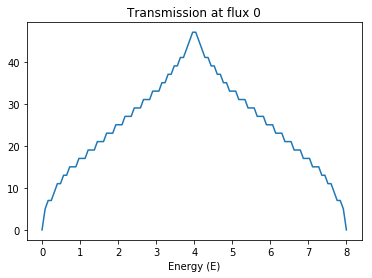

In [20]:
params = Parameters()
params.N_z = 2
params.N_phi = 50
params.flux = 0
params.t_z = 1
params.t_phi = 1*np.exp(1j*2*np.pi*params.flux/params.N_phi)
params.mu = 0
params.kT = 1e-5

E_linspace = np.linspace(0,8,100)
I = np.array([calc_current(E,params) for E in E_linspace])

plt.figure(i)
plt.plot(E_linspace,I)
plt.xlabel('Energy (E)')
plt.title("Transmission at flux " + str(params.flux))

I am studying the variation of T near the Fermi level.

## Transmission function map 

Transmission function map is T calculated as a function of the energy and the flux.

In [42]:
def calc_T(flux):
    print("Flux : ",flux)
    params = Parameters()
    params.N_z = 2
    params.N_phi = 10
    params.flux = flux
    params.t_z = 1
    params.t_phi = 1*np.exp(1j*2*np.pi*params.flux/params.N_phi)
    params.mu = 0
    params.kT = 1e-3

    E_linspace = np.linspace(0,8,100)
    T = np.array([calc_current(E,params) for E in E_linspace])
    return T

T_map = np.array([calc_T(flux) for flux in np.linspace(0,2,100)])

Flux :  0.0
Flux :  0.020202020202
Flux :  0.040404040404
iter_limit hit in calculation of surface_g 2.21283628085e-06
iter_limit hit in calculation of surface_g 2.21283628085e-06
Flux :  0.0606060606061
Flux :  0.0808080808081
Flux :  0.10101010101
Flux :  0.121212121212
Flux :  0.141414141414
Flux :  0.161616161616
Flux :  0.181818181818
Flux :  0.20202020202
Flux :  0.222222222222
iter_limit hit in calculation of surface_g 6.38226504796e-06
iter_limit hit in calculation of surface_g 6.38226504796e-06
Flux :  0.242424242424
Flux :  0.262626262626
Flux :  0.282828282828
iter_limit hit in calculation of surface_g 2.02915551012e-06
iter_limit hit in calculation of surface_g 2.02915551012e-06
Flux :  0.30303030303
Flux :  0.323232323232
Flux :  0.343434343434
Flux :  0.363636363636
Flux :  0.383838383838
Flux :  0.40404040404
Flux :  0.424242424242
Flux :  0.444444444444
Flux :  0.464646464646
Flux :  0.484848484848
Flux :  0.505050505051
Flux :  0.525252525253
Flux :  0.545454545455
Flu

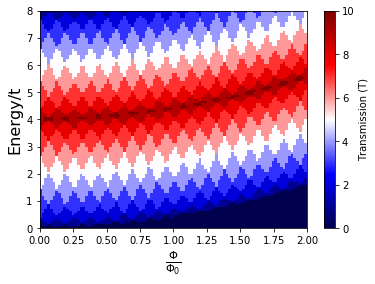

In [48]:
XX,YY = np.meshgrid(np.linspace(0,2,100),np.linspace(0,8,100))
plt.pcolor(XX,YY,T_map.T,cmap="seismic")
plt.xlabel(r"$\frac{\Phi}{\Phi_0}$",fontsize=16)
plt.ylabel("Energy/t",fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Transmission (T)')